In [22]:
# Import modules
%matplotlib inline
from IPython.display import clear_output

import os
import pydot
import pylab
import random
import numpy as np
import pandas as pd
import cPickle as pkl

from vis import *
from skimage import transform
from scipy.misc import imread, imresize
from skimage.exposure import adjust_gamma
from sklearn.preprocessing import LabelEncoder

from lasagne import layers, updates, nonlinearities
from nolearn.lasagne import NeuralNet, BatchIterator, visualize


project_root = os.path.join(os.path.expanduser('~'), 
                            'workspace/right_whale')
data_root = os.path.join(project_root, 'data')
subs_root = os.path.join(project_root, 'subs')
model_root = os.path.join(project_root, 'models')

In [23]:
lb  = LabelEncoder()

In [24]:
# load train and test 
train = pd.read_csv(os.path.join(data_root, 'train.csv'))
test = pd.read_csv(os.path.join(data_root, 'sample_submission.csv'))

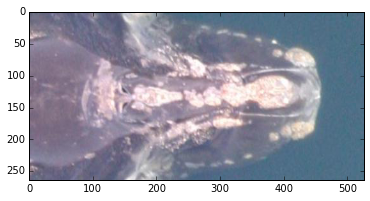

In [25]:
# visualize data
img = imread(data_root+"/traincrops/"+train.Image[0])
pylab.imshow(img)

In [26]:
train.head()

,Image,whaleID
0,w_7812.jpg,whale_48813
1,w_4598.jpg,whale_09913
2,w_3828.jpg,whale_45062
3,w_8734.jpg,whale_74162
4,w_3251.jpg,whale_99558


In [27]:
scale = 384

class TransIterator(BatchIterator):
    def transform(self, Xb, yb):
        Xb, yb = super(TransIterator, self).transform(Xb, yb)
        
        Xb_aug = []
        yb_aug = yb


        for i in Xb:
            # load framed image
            if yb is None:
                img=imread((data_root+"/testcrops/" + i))
            else:
                img=imread((data_root+"/traincrops/" + i))
            img = imresize(img, (scale, scale))
            #img = imresize(img, (img.shape[0]*scale/img.shape[1], scale))
            #temp = (scale - img.shape[0])//2
            #img = np.pad(img, [(temp, temp), (0, 0), (0, 0)], mode='constant')

            # random adjustment of gamma
            img = adjust_gamma(img, random.uniform(0.5, 1.5))

            # random crop of each border
            x1, x2, y1, y2 = np.random.randint(1, 48, 4)
            img = img[y1:-y2, x1:-x2]

            # scale cropped region to square 320x320
            img = imresize(img, (320, 320))

            img = img - 0.5

            Xb_aug.append(img.astype('float32'))

        Xb_aug = np.stack(Xb_aug)

        Xb_aug = np.rollaxis(Xb_aug, 3, 1)

        return Xb_aug, yb_aug

In [28]:
#Define layers of network
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import DenseLayer
from lasagne.layers.dnn import Conv2DDNNLayer as Conv
from lasagne.layers.dnn import Pool2DDNNLayer as Pool

from lasagne.layers import batch_norm

from lasagne.nonlinearities import softmax, rectify
from lasagne.init import GlorotUniform

nfilt = 32

l = InputLayer((None, 3, 320, 320))
l = batch_norm(Conv(l, nfilt, 3, stride=2, nonlinearity=rectify, W=GlorotUniform(gain='relu')))

for _ in range(5):
    if nfilt >= 512:
        nfilt = 512
    l = batch_norm(Conv(l, nfilt, 3, stride=1, pad=1, nonlinearity=rectify, W=GlorotUniform(gain='relu')))
    l = batch_norm(Conv(l, nfilt, 3, stride=1, pad=0, nonlinearity=rectify, W=GlorotUniform(gain='relu')))
    l = Pool(l, 2, stride=2)
    nfilt *= 2
l = batch_norm(Conv(l, nfilt, 3,stride=1, pad=0, nonlinearity=rectify, W=GlorotUniform(gain='relu')))

l = DropoutLayer(l, p=0.8)
layer = DenseLayer(l, num_units=447, nonlinearity=softmax, W=GlorotUniform(gain='relu'))

In [29]:
# create architecture
net=NeuralNet(
    layer,
    
    batch_iterator_train = TransIterator(batch_size = 32),
    batch_iterator_test = TransIterator(batch_size = 10),
    
    update=updates.adam,
    
    use_label_encoder = True,
    regression=False,
    max_epochs=1,
    verbose=1,
    )

In [30]:
net.initialize_layers()
with open(model_root + '/trained_convnet_78_epochs.pkl','r') as f:
    pvs = pkl.load(f)
f.close()

layers.set_all_param_values(layer, pvs)

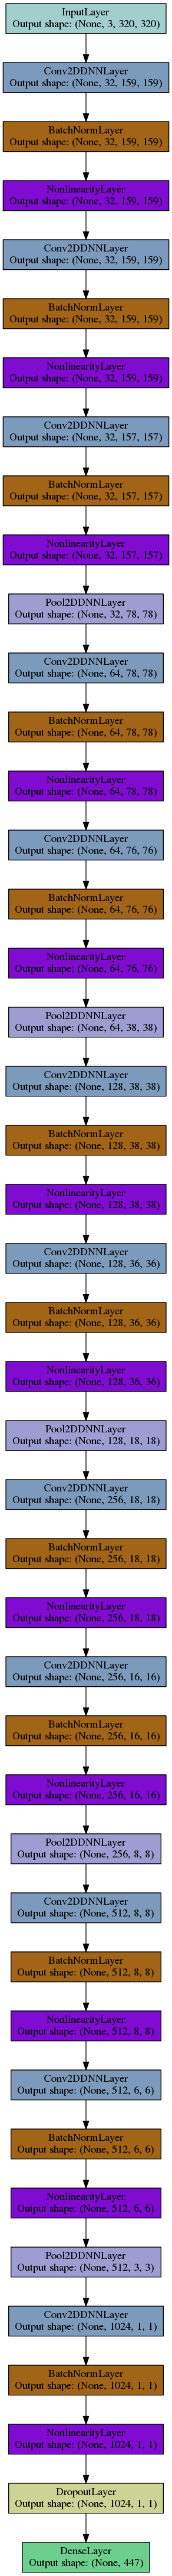

In [31]:
draw_to_notebook(net.get_all_layers())

In [32]:
# fit
net.fit(train.Image, train.whaleID);

# Neural Network with 9908383 learnable parameters

## Layer information

  #    name  size
---  ------  ----------
  0          3x320x320
             32x159x159
             32x159x159
             32x159x159
             32x159x159
             32x159x159
             32x159x159
             32x157x157
             32x157x157
             32x157x157
             32x78x78
             64x78x78
             64x78x78
             64x78x78
             64x76x76
             64x76x76
             64x76x76
             64x38x38
             128x38x38
             128x38x38
             128x38x38
             128x36x36
             128x36x36
             128x36x36
             128x18x18
             256x18x18
             256x18x18
             256x18x18
             256x16x16
             256x16x16
             256x16x16
             256x8x8
             512x8x8
             512x8x8
             512x8x8
             512x6x6
             512x6x6
             512x6x6
             512x3x3
  

/home/cuda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [33]:
# test
i = random.randrange(0, test.shape[0])

print net.predict(pd.Series(test.Image[i]))

['whale_95370']
